# Pescanova Micro Notebook
* The **input** is a 6-pack image of agars with colonies.
* The desired **output** is a table with a prediction of how many vibrios/staphylos are in each row.

In [32]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

### Step 1: Picture to pred_on_all_agars
* First thing is identify position of agars and crop them:

In [33]:
# Read image
img = cv2.imread('tests/test_micro_plate_1.png')

In [34]:
# Import models: agar detection and colony detection
modelAgarsWells = YOLO('models/sample_model/model_agars_wells.pt')
modelColonies = YOLO('models/sample_model/model_all_augment.pt')

In [35]:
resultsAgars = modelAgarsWells(img)[0]
allBoxes = resultsAgars.boxes.xyxy.numpy().astype(int)

# These are the coordinates of the top-left corner of each agar
allBoxes[:, 0:2]


0: 384x640 6 agars, 46.3ms
Speed: 2.4ms preprocess, 46.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


array([[ 681,  382],
       [1733, 1327],
       [ 720, 1350],
       [1705,  351],
       [2759, 1284],
       [2708,  316]])

In [36]:
def get_positions(circles, num_rows, num_cols):
    import numpy as np
    from sklearn.cluster import KMeans

    # Location algorithm for desired pocillo    
    x_kmeans = KMeans(n_clusters=num_cols, n_init=num_cols-1).fit(circles[:,0].reshape(-1, 1))
    x_labels, x_centers = x_kmeans.labels_, x_kmeans.cluster_centers_.squeeze()
    
    x_new_labels = np.zeros_like(x_labels)
    for i in range(len(x_centers)):
        x_new_labels[x_labels == i] = np.where(np.argsort(x_centers) == i)[0][0] 

    y_kmeans = KMeans(n_clusters=num_rows, n_init=num_rows-1).fit(circles[:,1].reshape(-1, 1))
    y_labels, y_centers = y_kmeans.labels_, y_kmeans.cluster_centers_.squeeze()
    
    y_new_labels = np.zeros_like(y_labels)
    for i in range(len(y_centers)):
        y_new_labels[y_labels == i] = np.where(np.argsort(y_centers) == i)[0][0]
        
    # Output is a dataframe where each row corresponds to a different circle.
    # We give coordinates of center, value of radius, row number and column number (in the grid)
    
    return np.column_stack((circles, y_new_labels+1,  x_new_labels+1))

In [37]:
agarsPositions = get_positions(allBoxes[:, 0:2], 2, 3)

# Sort the array first by the last column (index 3), then by the one before column (index 2)
sorted_indices = np.lexsort((agarsPositions[:, 3], agarsPositions[:, 2]))
# Here sorting is top-down, and left-right, so like:
# 1 2 3
# 4 5 6 
allBoxesSorted = allBoxes[sorted_indices]

* We next define *pred_on_all_agars*, a list of dictionaries containing colonies of each agar.

In [38]:
def get_path_dict(results):
    names = results[0].names
    number_colonies = np.zeros((len(names)), dtype = int)
    for i in range(0, len(results[0])):
        box = results[0].boxes[i]
        class_id = int(box.cls[0].item())
        number_colonies[class_id] = number_colonies[class_id] + 1

    counting = {}
    for i in range(0, len(names)):
        bacteria_name = names.get(i)
        counting[bacteria_name] = int(number_colonies[i])

    return counting


0: 640x640 6 valginos, 102.6ms
Speed: 5.9ms preprocess, 102.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


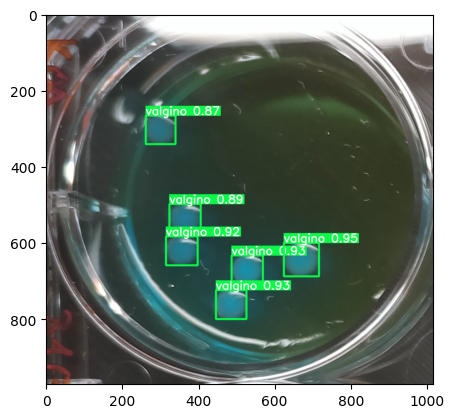


0: 640x640 10 valginos, 84.2ms
Speed: 2.3ms preprocess, 84.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


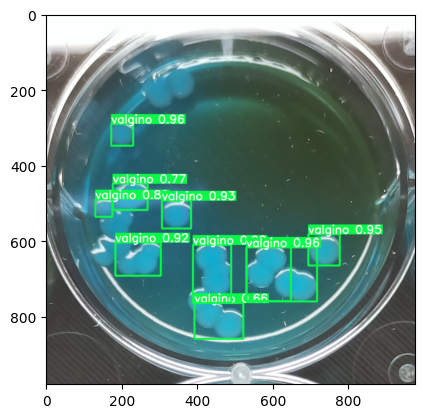


0: 640x640 14 valginos, 79.2ms
Speed: 2.3ms preprocess, 79.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


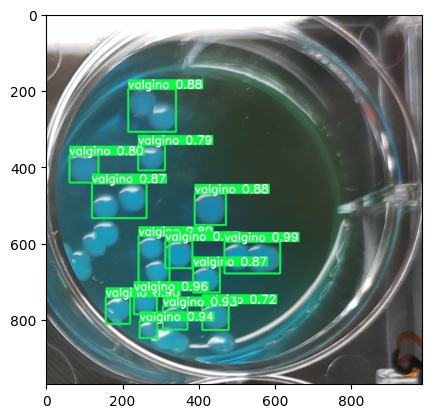


0: 640x640 2 pddamselaes, 3 valginos, 92.2ms
Speed: 4.4ms preprocess, 92.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


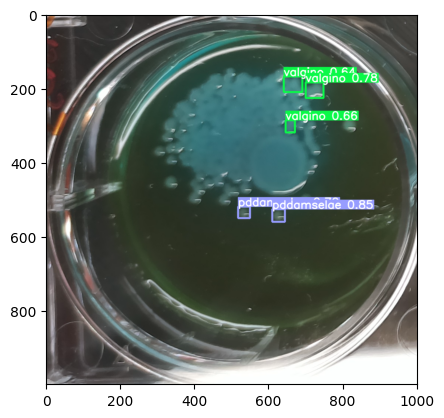


0: 608x640 (no detections), 126.4ms
Speed: 2.0ms preprocess, 126.4ms inference, 0.3ms postprocess per image at shape (1, 3, 608, 640)


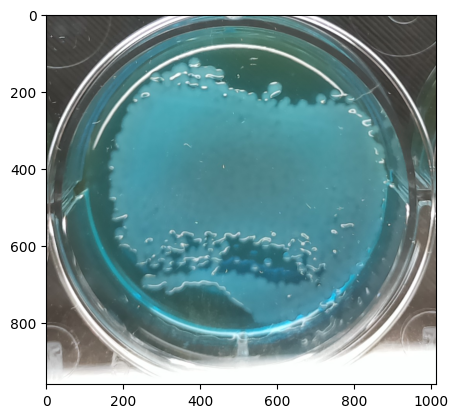


0: 640x640 1 valgino, 79.6ms
Speed: 3.5ms preprocess, 79.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


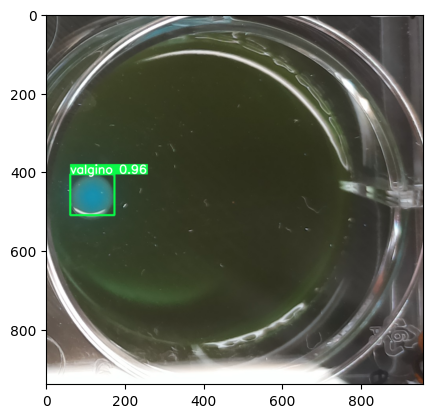

In [40]:
pred_on_all_agars = []
pred_images = []

for box in allBoxesSorted:
    agarCrop = img[box[1]:box[3], box[0]:box[2]]

    # agarCrop = img.crop((box[0], box[1], box[2], box[3])) #for PIL images

    # Colonies prediction on agarCrop
    results = modelColonies.predict(agarCrop, conf = .6)
    # Get count of each pathogen type
    path_dict = get_path_dict(results)
    # Plot results
    prediction_image = results[0].plot()
    pred_images.append(prediction_image)
    plt.imshow(prediction_image)
    plt.show()

    # Append global list
    pred_on_all_agars.append(path_dict)

In [43]:
pred_images[0]

array([[[120, 114, 115],
        [109, 104, 105],
        [ 99,  94,  95],
        ...,
        [253, 255, 254],
        [253, 255, 254],
        [253, 255, 254]],

       [[106, 101, 102],
        [ 96,  91,  92],
        [ 96,  91,  92],
        ...,
        [253, 255, 254],
        [253, 255, 254],
        [253, 255, 254]],

       [[ 98,  93,  94],
        [ 93,  88,  89],
        [ 95,  93,  93],
        ...,
        [253, 255, 254],
        [253, 255, 254],
        [253, 255, 254]],

       ...,

       [[ 96,  59,  51],
        [ 96,  62,  56],
        [ 98,  69,  62],
        ...,
        [ 68,  66,  65],
        [ 69,  67,  66],
        [ 70,  68,  67]],

       [[105,  56,  46],
        [102,  56,  48],
        [100,  61,  52],
        ...,
        [ 67,  65,  64],
        [ 68,  66,  65],
        [ 69,  67,  66]],

       [[121,  59,  48],
        [115,  60,  47],
        [110,  61,  47],
        ...,
        [ 65,  63,  62],
        [ 68,  66,  65],
        [ 69,  67,  66]]

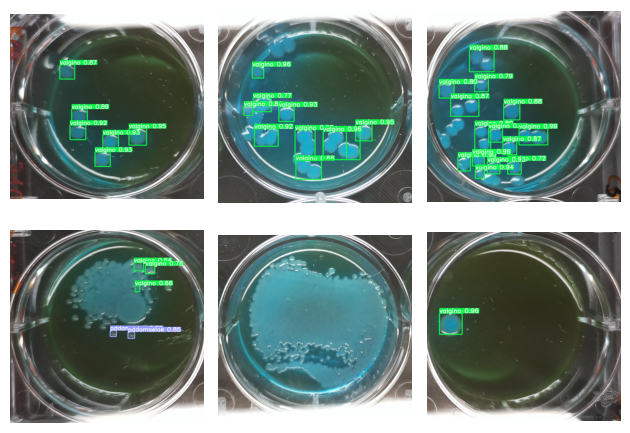

In [51]:
# Create a figure with 2 rows and 3 columns
fig, axarr = plt.subplots(2, 3)

# Display each image in its corresponding subplot
axarr[0, 0].imshow(pred_images[0])
axarr[0, 1].imshow(pred_images[1])
axarr[0, 2].imshow(pred_images[2])
axarr[1, 0].imshow(pred_images[3])
axarr[1, 1].imshow(pred_images[4])
axarr[1, 2].imshow(pred_images[5])


# Remove axis ticks and labels for better visualization
for ax in axarr.flat:
    ax.axis('off')

# Adjust layout to prevent clipping of the subplot titles
plt.tight_layout()

from matplotlib.backends.backend_agg import FigureCanvasAgg

# Render the figure to a numpy array
canvas = FigureCanvasAgg(fig)
canvas.draw()
combined_image = np.array(canvas.renderer.buffer_rgba())


### Step 2: From pred_on_all_agars to pred_on_rows

In [12]:
# The official column order for agars is: TCBS - MSA - BA
upperRowTCBS, upperRowMSA, upperRowBA, lowerRowTCBS, lowerRowMSA, lowerRowBA= pred_on_all_agars[0], pred_on_all_agars[1], pred_on_all_agars[2], pred_on_all_agars[3], pred_on_all_agars[4], pred_on_all_agars[5]

# After **some logic** we get to a final prediction
upperRowPred, lowerRowPred = upperRowBA, lowerRowBA

In [16]:
if len(pred_on_all_agars)==6:
    # The official column order for agars is: TCBS - MSA - BA
    upperRowTCBS, upperRowMSA, upperRowBA, lowerRowTCBS, lowerRowMSA, lowerRowBA= pred_on_all_agars[0], pred_on_all_agars[1], pred_on_all_agars[2], pred_on_all_agars[3], pred_on_all_agars[4], pred_on_all_agars[5]

    # After **some logic** we get to a final prediction
    upperRowPred, lowerRowPred = upperRowBA, lowerRowBA

else:
    upperRowTCBS, upperRowMSA, upperRowBA, lowerRowTCBS, lowerRowMSA, lowerRowBA, upperRowPred, lowerRowPred = {}, {}, {}, {}, {}, {}, {}, {} 


In [12]:
# To get a prediction on a row, we just look at the first agar (**this will need to be changed**)
# The result of arow-prediction is a count of vibrios, and a count of staphylos (at the moment there are not staphylo labels, so I'm just taking inniae, **this will also need to be changed**)

def get_row_pred(Row):
    row_pred = {'vibrios': Row[0]['valgino'] + Row[0]['vangil'] + Row[0]['vharveyi'],
     'staphylos': Row[0]['sinniae']}
    
    return row_pred

In [13]:
pred_on_rows = {'upperRow': get_row_pred(upperRow),'lowerRow': get_row_pred(lowerRow)}
pred_on_rows

{'upperRow': {'vibrios': 7, 'staphylos': 0},
 'lowerRow': {'vibrios': 15, 'staphylos': 0}}

### Step 3: From pred_on_rows to DB

In [21]:
sample_db_entry = {'plate_id': ['PESCXXXX'],
                   'date': ['00/00/00'],
                   'time': ['00:00:00'],
                   'upperRowVibrios': [pred_on_rows['upperRow']['vibrios']],
                   'upperRowStaphylos': [pred_on_rows['upperRow']['staphylos']],
                   'lowerRowVibrios': [pred_on_rows['lowerRow']['vibrios']],
                   'lowerRowStaphylos': [pred_on_rows['lowerRow']['staphylos']]}

In [22]:
pd.DataFrame(sample_db_entry)

,plate_id,date,time,upperRowVibrios,upperRowStaphylos,lowerRowVibrios,lowerRowStaphylos
0,PESCXXXX,00/00/00,00:00:00,7,0,15,0


#### Remark
* It's important to note that the predictions are made on **cropped images**, so the counts of vibrio/staphylo obtained may not match the ones on this image!


0: 384x640 28 valginos, 1 vangil, 2 vharveyis, 70.3ms
Speed: 6.9ms preprocess, 70.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


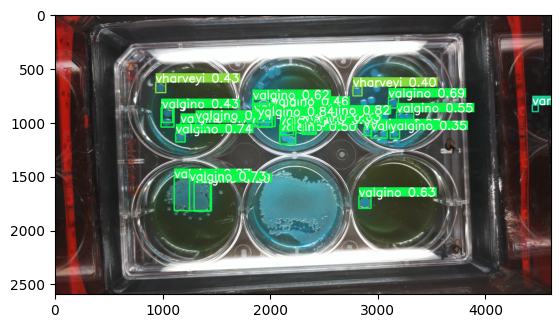

In [81]:
plt.imshow(modelColonies(img)[0].plot())

# Post processing filters

In [1]:
def post_processing_filter(path_counting, agar_type):

    # Define pathogens that have **no growth** in each of the media
    bloodNoGrowth, tcbsNoGrowth = {'tmaritimum'}, {'assalmonicida', 'pddamselae', 'pdpiscicida', 'tmaritimum'}

    # Replace with 0's all entries that contradict the no-growth theoretical data
    if agar_type == 'BA':
        for path in bloodNoGrowth:
            path_counting[path] = 0

    if agar_type == 'TCBS':
        for path in tcbsNoGrowth:
            path_counting[path] = 0
    
    return path_counting    

In [2]:
my_test_path_counting = {'assalmonicida': 0,
 'pddamselae': 1,
 'pdpiscicida': 0,
 'sinniae': 0,
 'tmaritimum': 0,
 'valgino': 15,
 'vangil': 2,
 'vharveyi': 0}

In [3]:
post_processing_filter(my_test_path_counting, 'TCBS')

{'assalmonicida': 0,
 'pddamselae': 0,
 'pdpiscicida': 0,
 'sinniae': 0,
 'tmaritimum': 0,
 'valgino': 15,
 'vangil': 2,
 'vharveyi': 0}